#Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import seaborn as sns; sns.set()

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import math

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Adding a new variable: 'Season' based on the time variable

In [3]:
# load the data
#df = pd.read_csv('/content/drive/My Drive/GRP_PROJ_BA476/datasets/energydata_complete.csv')
df = pd.read_csv('/content/drive/My Drive/energydata_complete.csv') #everyone should use this which means you need to have the dataset in your respective 'my drive'
df.head()

#use github and load data from there

# now adding 'season' variable based on the 'date' column
# 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# if statement for assigning seasons
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# new 'season' column
df['season'] = df['date'].dt.month.apply(assign_season)

# Checking the distribution of seasons
print("Season distribution:\n", df['season'].value_counts())



Season distribution:
 season
Spring    12637
Winter     7098
Name: count, dtype: int64


#Checking for outliers

Number of rows removed: 1000
Dataset size before removal: 19735
Dataset size after removal: 18735
Number of rows removed: 1000


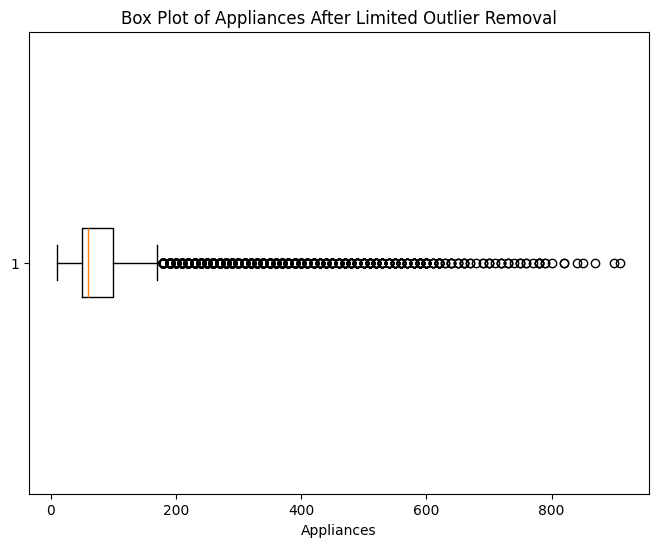

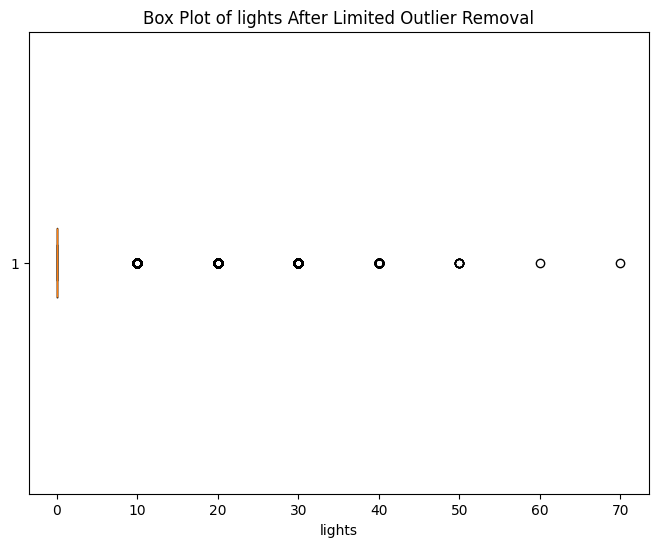

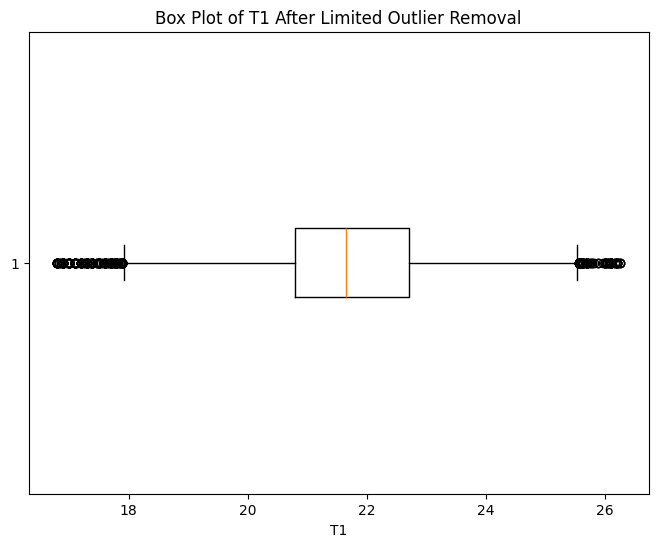

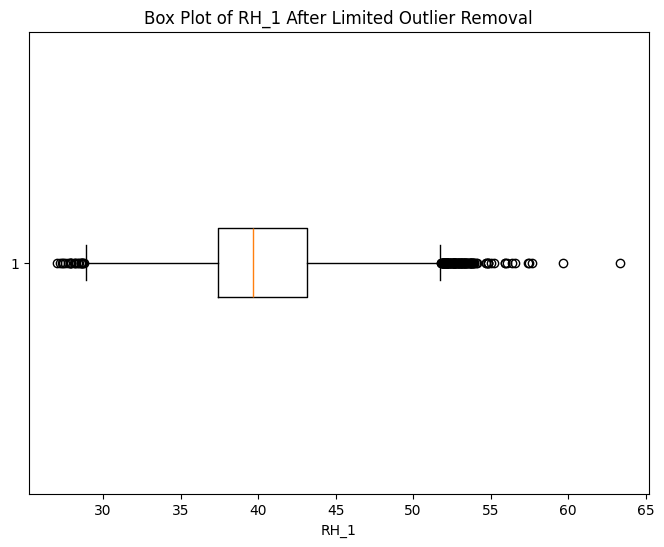

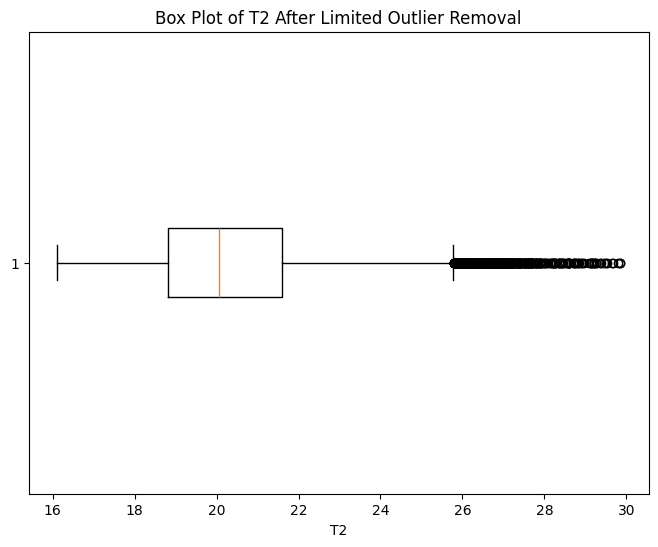

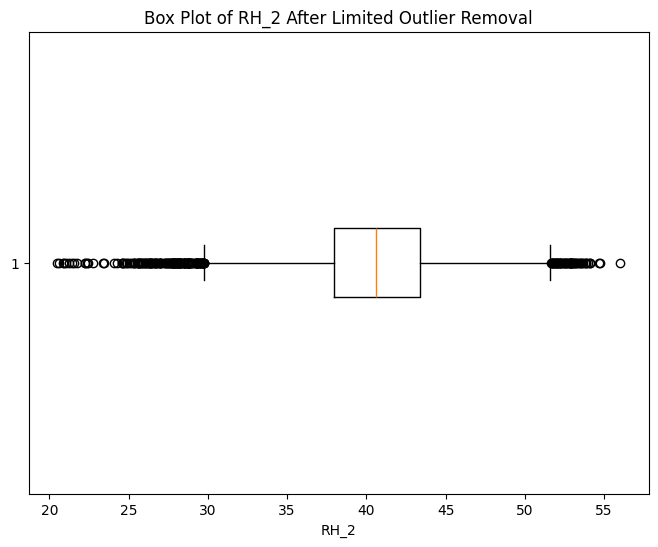

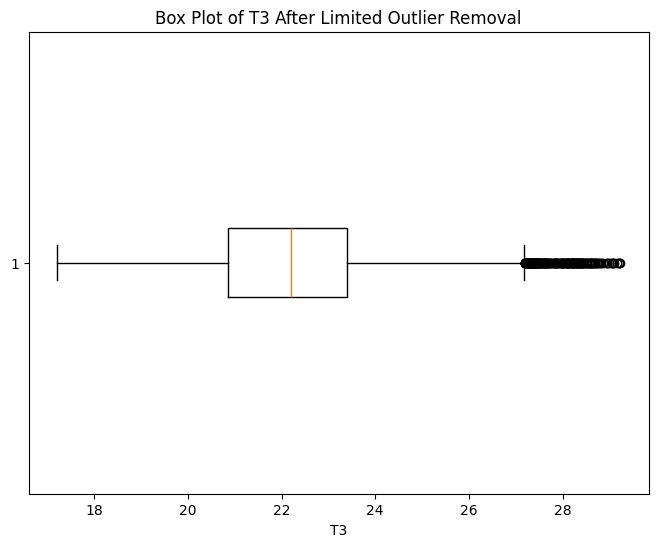

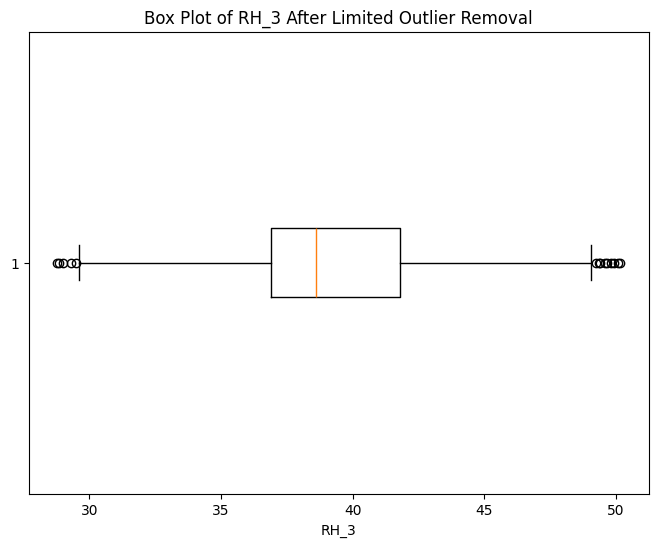

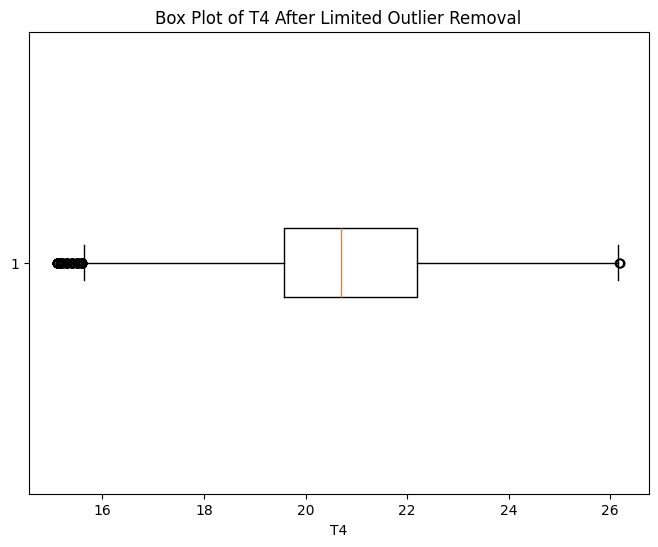

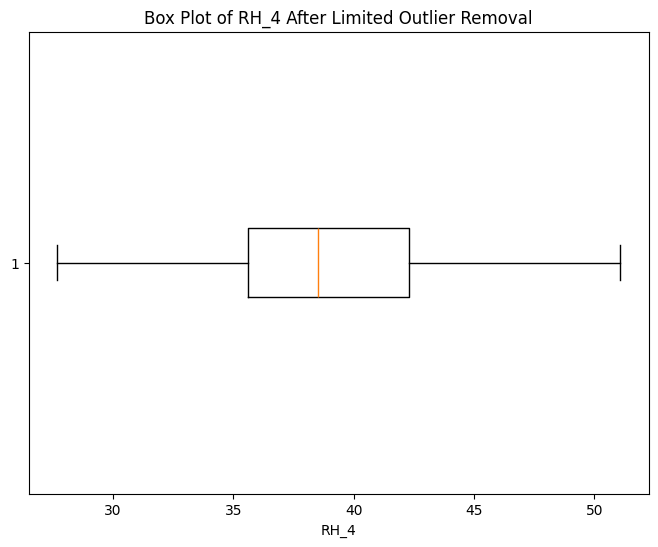

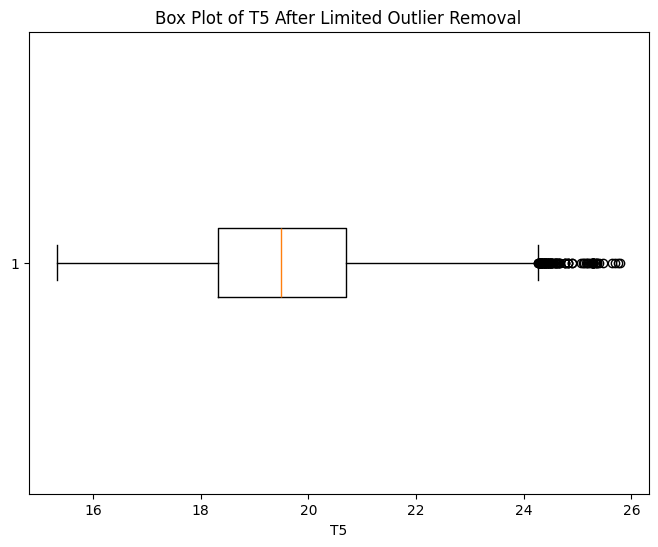

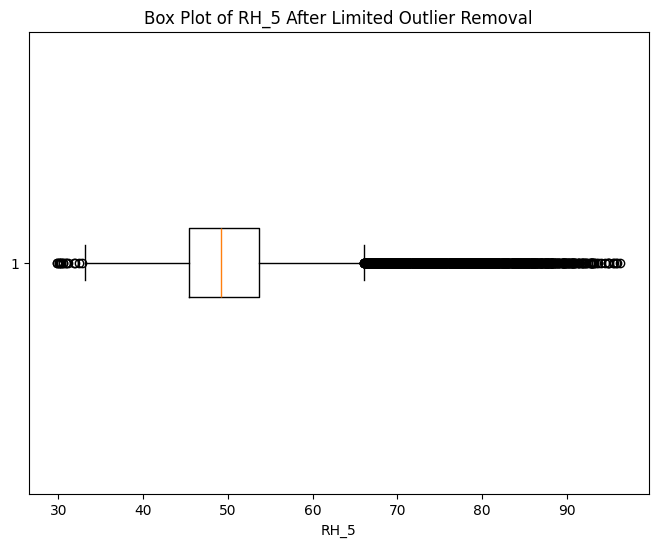

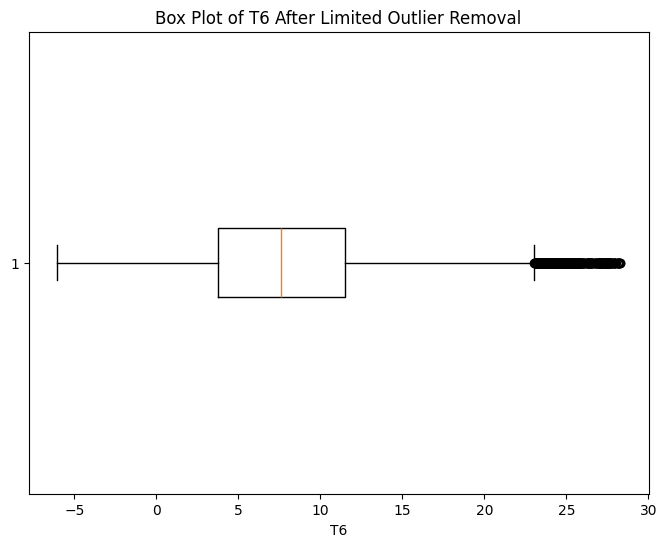

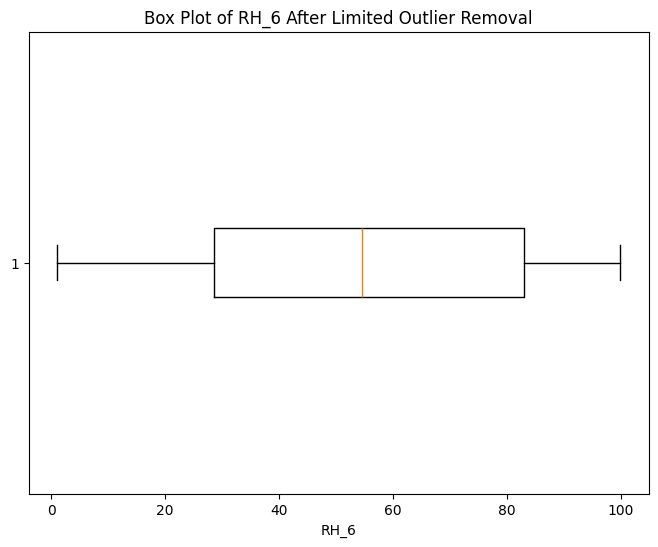

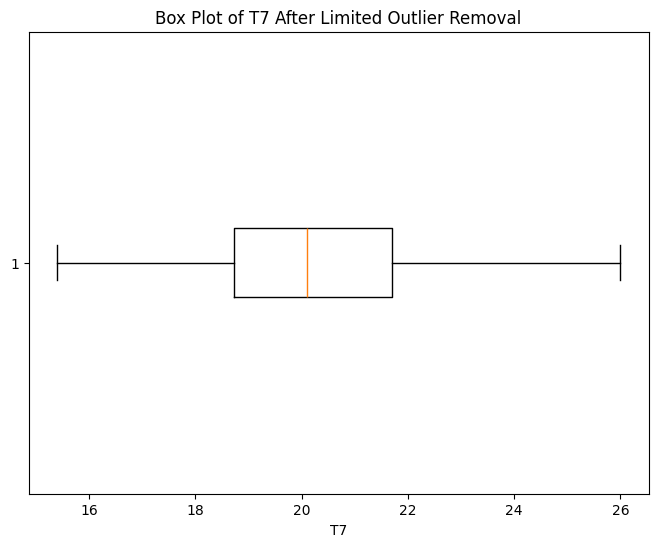

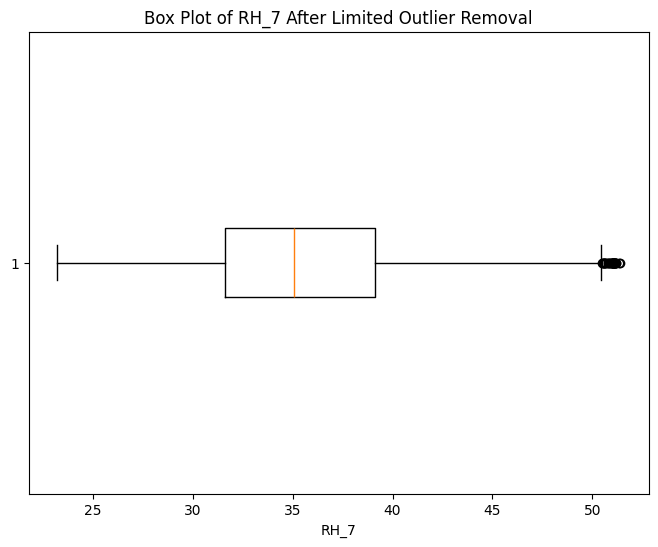

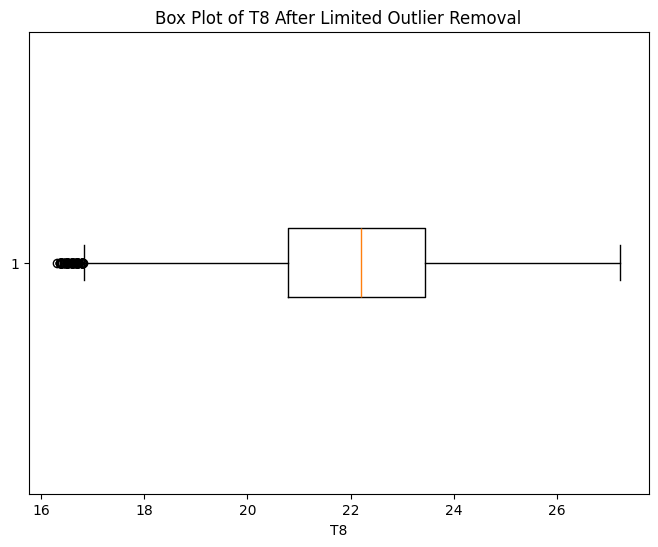

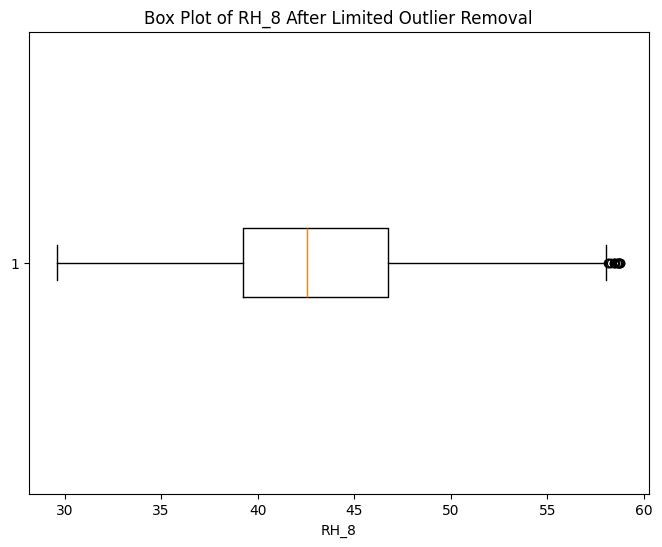

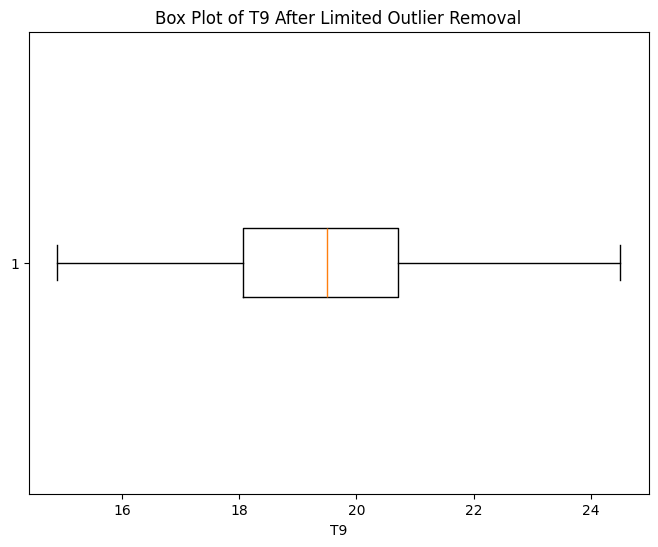

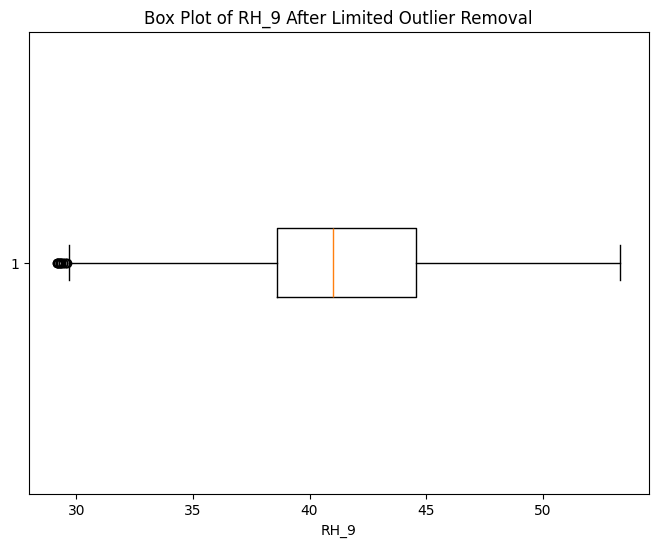

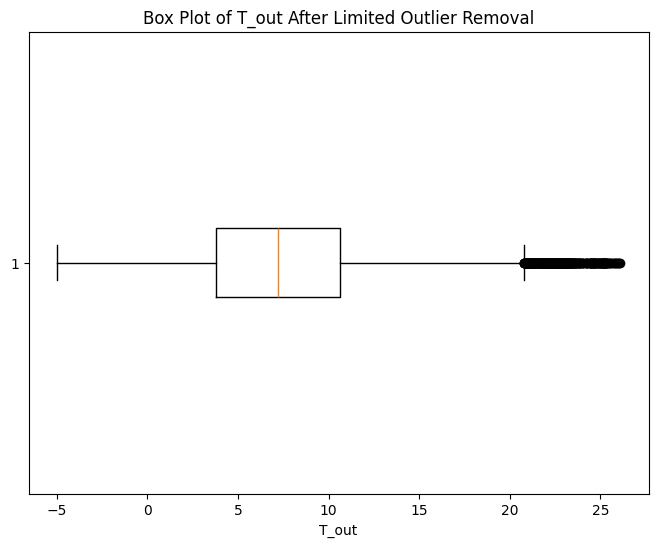

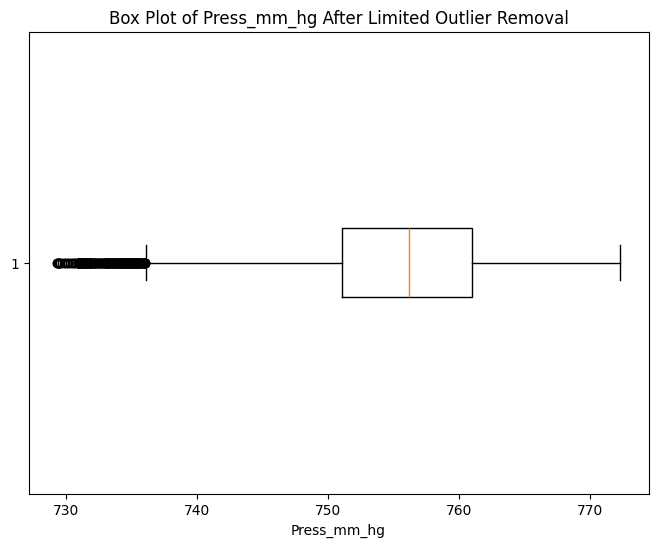

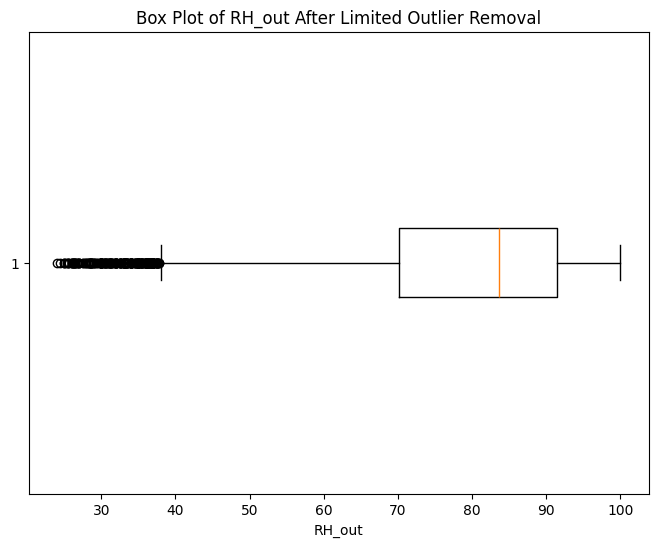

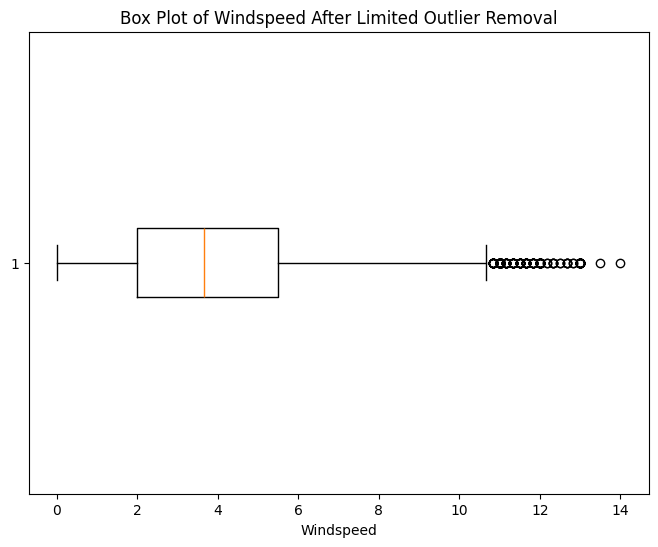

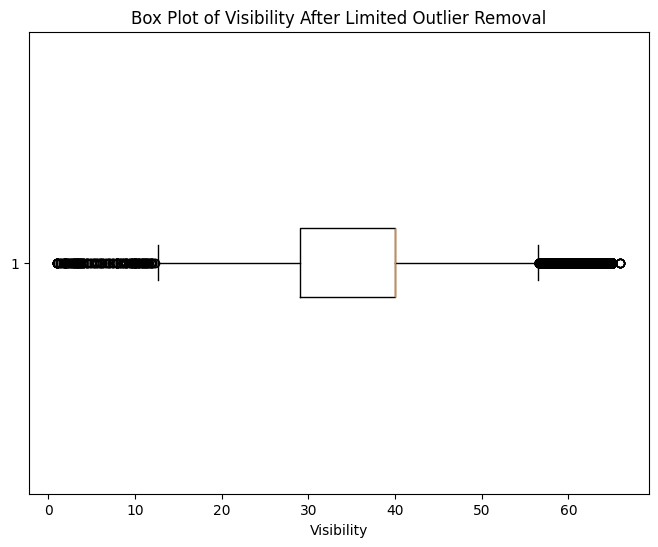

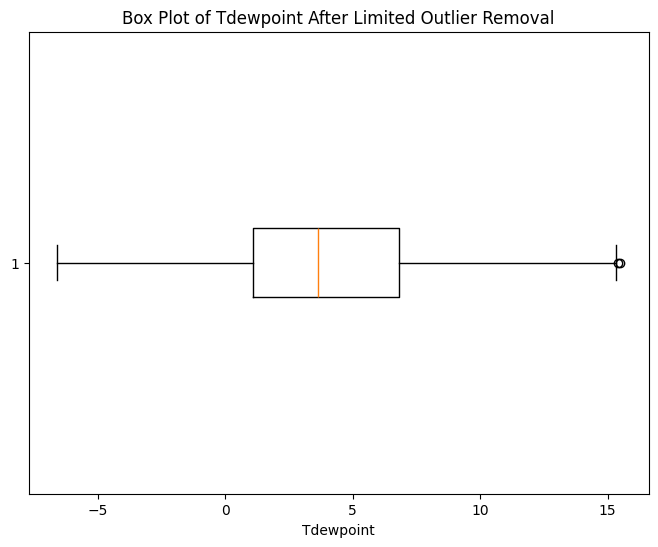

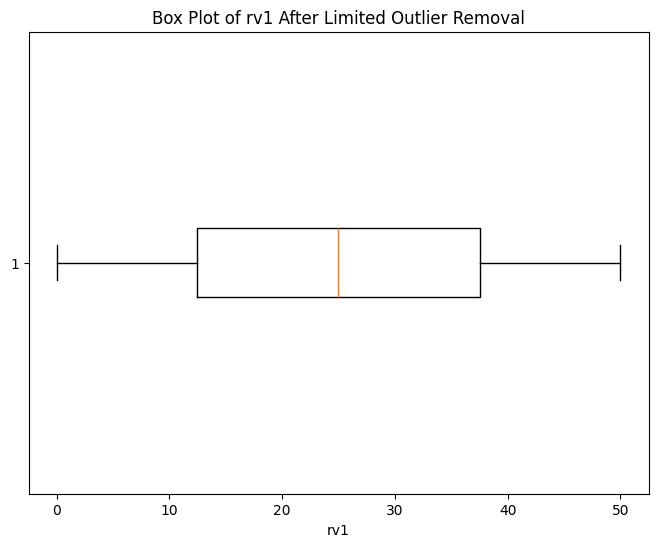

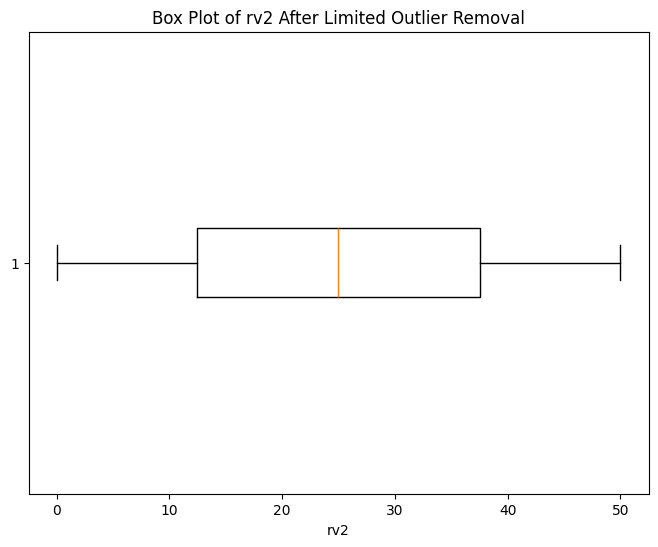

In [4]:
# Function to remove outliers using a single-pass IQR threshold with a cap on rows removed
def remove_outliers_iqr_fast(data, features, threshold=10.0, max_removed=1000):
    """
    Removes outliers based on IQR with a cap on the number of rows removed.

    Args:
    - data: DataFrame to analyze.
    - features: List of numerical features.
    - threshold: IQR multiplier for defining outlier bounds.
    - max_removed: Maximum number of rows to remove.

    Returns:
    - cleaned_data: DataFrame after outlier removal.
    - removed_count: Number of rows removed.
    """
    cleaned_data = data.copy()

    # Calculate IQR bounds for all features
    outlier_flags = pd.DataFrame(False, index=data.index, columns=features)
    for feature in features:
        Q1 = cleaned_data[feature].quantile(0.25)
        Q3 = cleaned_data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outlier_flags[feature] = (cleaned_data[feature] < lower_bound) | (cleaned_data[feature] > upper_bound)

    # Count total outliers per row
    row_outliers = outlier_flags.sum(axis=1)

    # Sort rows by number of features flagged as outliers (most extreme first)
    row_outliers_sorted = row_outliers.sort_values(ascending=False)

    # Identify rows to keep
    rows_to_remove = row_outliers_sorted.iloc[:max_removed].index
    cleaned_data = cleaned_data.drop(index=rows_to_remove)

    removed_count = len(rows_to_remove)
    print(f"Number of rows removed: {removed_count}")
    return cleaned_data, removed_count


# Select numerical features
numerical_features = df.select_dtypes(include=np.number).columns

# Apply the function
initial_size = df.shape[0]
df_cleaned, removed_count = remove_outliers_iqr_fast(df, numerical_features, threshold=10.0, max_removed=1000)

# Output results
final_size = df_cleaned.shape[0]
print(f"Dataset size before removal: {initial_size}")
print(f"Dataset size after removal: {final_size}")
print(f"Number of rows removed: {removed_count}")

# Visualize remaining data using boxplots
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    plt.boxplot(df_cleaned[feature], vert=False)
    plt.title(f"Box Plot of {feature} After Limited Outlier Removal")
    plt.xlabel(feature)
    plt.show()


# Data Visualizations

**VARIABLE INFORMATION**

date time year-month-day hour:minute:second

*Appliances, energy use in Wh*   **target variable**

lights, energy use of light fixtures in the house in Wh

T1, Temperature in kitchen area, in Celsius

RH_1, Humidity in kitchen area, in %

T2, Temperature in living room area, in Celsius

RH_2, Humidity in living room area, in %

T3, Temperature in laundry room area

RH_3, Humidity in laundry room area, in %

T4, Temperature in office room, in Celsius

RH_4, Humidity in office room, in %

T5, Temperature in bathroom, in Celsius

RH_5, Humidity in bathroom, in %

T6, Temperature outside the building (north side), in Celsius

RH_6, Humidity outside the building (north side), in %

T7, Temperature in ironing room , in Celsius

RH_7, Humidity in ironing room, in %

T8, Temperature in teenager room 2, in Celsius

RH_8, Humidity in teenager room 2, in %

T9, Temperature in parents room, in Celsius

RH_9, Humidity in parents room, in %

To, Temperature outside (from Chievres weather station), in Celsius

Pressure (from Chievres weather station), in mm Hg

RH_out, Humidity outside (from Chievres weather station), in %

Wind speed (from Chievres weather station), in m/s

Visibility (from Chievres weather station), in km

Tdewpoint (from Chievres weather station), Â°C

rv1, Random variable 1, nondimensional

rv2, Random variable 2, nondimensional

Where indicated, hourly data (then interpolated) from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis, rp5.ru. Permission was obtained from Reliable Prognosis for the distribution of the 4.5 months of weather data.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         19735 non-null  datetime64[ns]
 1   Appliances   19735 non-null  int64         
 2   lights       19735 non-null  int64         
 3   T1           19735 non-null  float64       
 4   RH_1         19735 non-null  float64       
 5   T2           19735 non-null  float64       
 6   RH_2         19735 non-null  float64       
 7   T3           19735 non-null  float64       
 8   RH_3         19735 non-null  float64       
 9   T4           19735 non-null  float64       
 10  RH_4         19735 non-null  float64       
 11  T5           19735 non-null  float64       
 12  RH_5         19735 non-null  float64       
 13  T6           19735 non-null  float64       
 14  RH_6         19735 non-null  float64       
 15  T7           19735 non-null  float64       
 16  RH_7

#Checking for duplicate values

In [6]:
#  checking if there is any duplicated values in the data set

# for duplicate rows
duplicate_rows = df[df.duplicated()]

if not duplicate_rows.empty:
  print("Duplicate rows found:")
  print(duplicate_rows)
else:
  print("No duplicates")

# duplicate values within columns
for column in df.columns:
  if df[column].duplicated().any():
    print(f"Duplicate values found: {column}")
    print(df[df[column].duplicated()][column])

#columns duplicates are expected, since a few continuous values in columns can be the same

No duplicates
Duplicate values found: Appliances
1         60
3         50
4         60
5         50
6         60
        ... 
19730    100
19731     90
19732    270
19733    420
19734    430
Name: Appliances, Length: 19643, dtype: int64
Duplicate values found: lights
1        30
2        30
4        40
5        40
7        50
         ..
19730     0
19731     0
19732    10
19733    10
19734    10
Name: lights, Length: 19727, dtype: int64
Duplicate values found: T1
1        19.890000
2        19.890000
3        19.890000
4        19.890000
5        19.890000
           ...    
19730    25.566667
19731    25.500000
19732    25.500000
19733    25.500000
19734    25.500000
Name: T1, Length: 19013, dtype: float64
Duplicate values found: RH_1
36       44.200000
37       44.200000
38       44.200000
42       44.560000
44       44.966667
           ...    
19729    46.860000
19730    46.560000
19731    46.500000
19732    46.596667
19733    46.990000
Name: RH_1, Length: 17188, dtype: float64
D

In [7]:
df.describe()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,2016-03-20 05:30:00,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,...,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
min,2016-01-11 17:00:00,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,...,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,2016-02-14 23:15:00,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,...,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,2016-03-20 05:30:00,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,...,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,2016-04-23 11:45:00,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,...,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,2016-05-27 18:00:00,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,...,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530
std,NaN,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,...,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634


#Distribuition of Application (our Y variable)

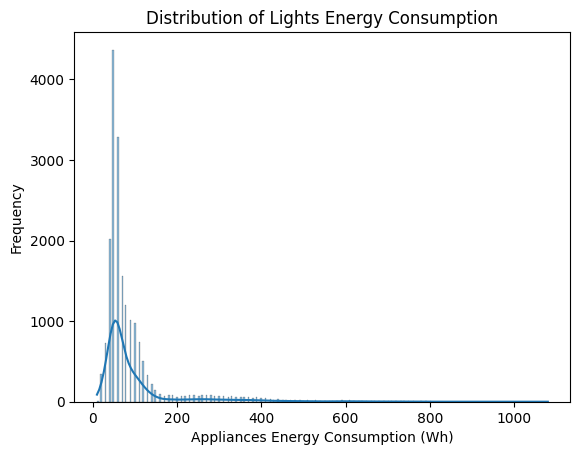

In [8]:
# Creating a histogram for lights to see its distribution using seaborns

import seaborn as sns

# Assuming 'lights' is the column you want to analyze
sns.histplot(df['Appliances'], kde=True)
plt.xlabel('Appliances Energy Consumption (Wh)')
plt.ylabel('Frequency')
plt.title('Distribution of Lights Energy Consumption')
plt.show()

### Distribution of target variabe: Appliacnes Energy Consumtion is skewed to the right, which can lead to inaccurate prediction with bias

     Option 1: SMOTE
     Option 2: Bootsrap
     Option 3: RandomSampler
     Option 4: Stratification

<Axes: xlabel='Appliances_log', ylabel='Count'>

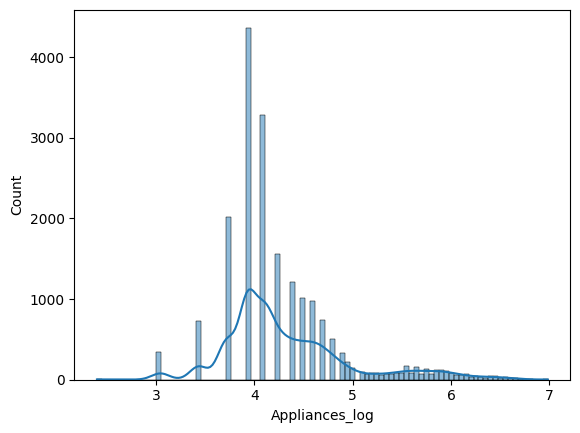

In [9]:
#transform applicances into log form and plotting a histogram

df['Appliances_log'] = np.log1p(df['Appliances'])
sns.histplot(df['Appliances_log'], kde=True)



# Make sure to use log transformed Appliacnes

In [10]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,season,Appliances_log
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,Winter,4.110874
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,Winter,4.110874
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,Winter,3.931826
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,Winter,3.931826
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,Winter,4.110874


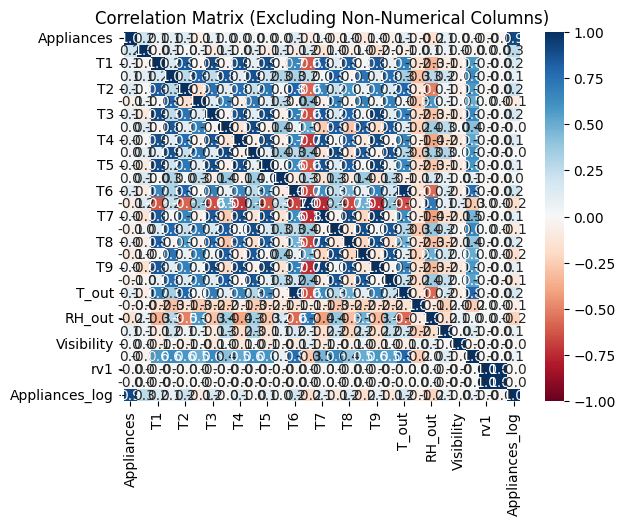

In [11]:
# correlation between independent variables where target variable is appliances

# Dropping non-numerical columns like 'date' and 'season'
df_without_date = df.drop(columns=['date', 'season'])

# Calculate the correlation matrix
corr_mat = df_without_date.corr()

sns.heatmap(corr_mat, annot=True, vmin=-1, vmax=1, fmt='.1f', cmap="RdBu")
plt.title("Correlation Matrix (Excluding Non-Numerical Columns)")
plt.show()


### Room 6 has negative correlation with all the temparature.

## We may need to standardize/scale the data

In [12]:
df.tail(10)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,season,Appliances_log
19725,2016-05-27 16:30:00,220,0,25.426667,46.060000,26.000000,41.700000,28.000000,40.760000,24.7,...,22.900000,755.35,55.000000,2.500000,22.500000,13.300000,23.009520,23.009520,Spring,5.398163
19726,2016-05-27 16:40:00,180,0,25.500000,46.530000,26.000000,41.725714,27.856667,40.500000,24.7,...,22.933333,755.30,55.000000,2.666667,22.333333,13.333333,25.296732,25.296732,Spring,5.198497
19727,2016-05-27 16:50:00,120,0,25.500000,47.456667,26.000000,42.320000,27.663333,40.693333,24.7,...,22.966667,755.25,55.000000,2.833333,22.166667,13.366667,1.796395,1.796395,Spring,4.795791
19728,2016-05-27 17:00:00,110,0,25.600000,47.193333,25.968571,42.528571,27.390000,41.030000,24.7,...,23.000000,755.20,55.000000,3.000000,22.000000,13.400000,18.248201,18.248201,Spring,4.709530
19729,2016-05-27 17:10:00,90,0,25.533333,46.860000,25.978000,42.534000,27.323333,41.090000,24.7,...,22.866667,755.20,55.333333,3.166667,22.833333,13.366667,16.966162,16.966162,Spring,4.510860
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,...,22.733333,755.20,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812,Spring,4.615121
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,...,22.600000,755.20,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940,Spring,4.510860
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,...,22.466667,755.20,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117,Spring,5.602119
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,...,22.333333,755.20,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784,Spring,6.042633
19734,2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,...,22.200000,755.20,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851,Spring,6.066108


#Graphs to understand relationships between variables

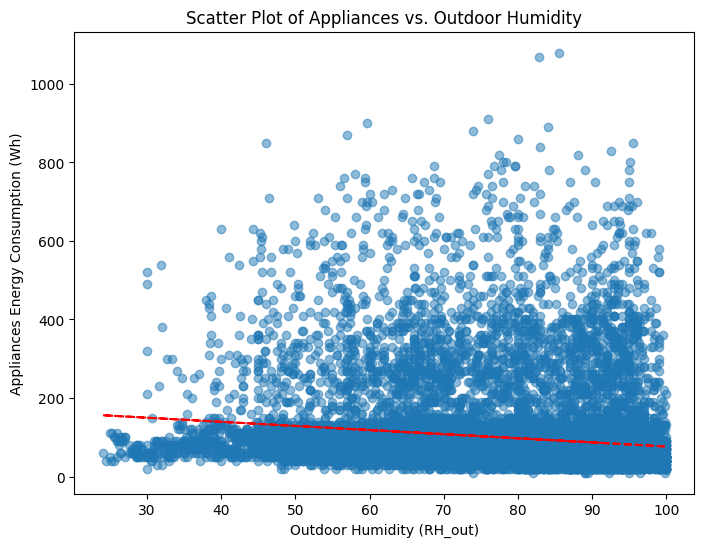

In [13]:
#plotting scatter plot with a trend line appliances variable and rh_out

plt.figure(figsize=(8, 6))
plt.scatter(df['RH_out'], df['Appliances'], alpha=0.5)
plt.xlabel('Outdoor Humidity (RH_out)')
plt.ylabel('Appliances Energy Consumption (Wh)')
plt.title('Scatter Plot of Appliances vs. Outdoor Humidity')

# Add a trend line using linear regression
z = np.polyfit(df['RH_out'], df['Appliances'], 1)
p = np.poly1d(z)
plt.plot(df['RH_out'], p(df['RH_out']), "r--")

plt.show()

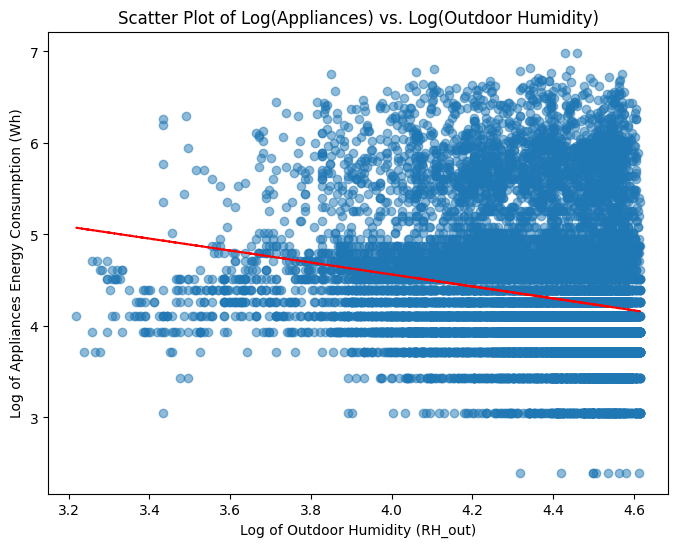

In [14]:
# do log-transform for appliances and RH_out and plot it with a trend line

# Log-transform 'Appliances' and 'RH_out'
df['Appliances_log'] = np.log1p(df['Appliances'])
df['RH_out_log'] = np.log1p(df['RH_out'])

# Plot the log-transformed data with a trend line
plt.figure(figsize=(8, 6))
plt.scatter(df['RH_out_log'], df['Appliances_log'], alpha=0.5)
plt.xlabel('Log of Outdoor Humidity (RH_out)')
plt.ylabel('Log of Appliances Energy Consumption (Wh)')
plt.title('Scatter Plot of Log(Appliances) vs. Log(Outdoor Humidity)')

z = np.polyfit(df['RH_out_log'], df['Appliances_log'], 1)
p = np.poly1d(z)
plt.plot(df['RH_out_log'], p(df['RH_out_log']), "r--")

plt.show()

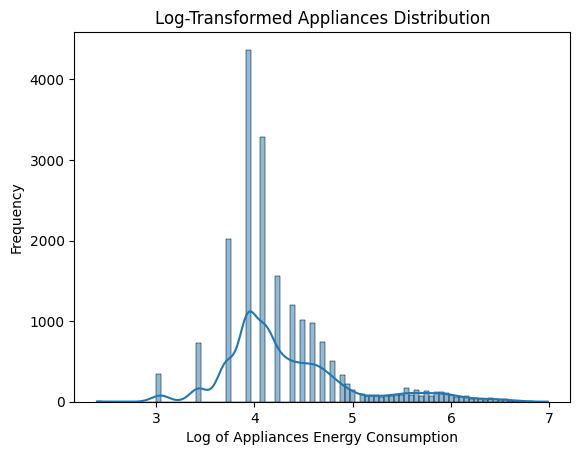

In [15]:
# Plot distribution of log-transformed Appliances
sns.histplot(df['Appliances_log'], kde=True)
plt.title("Log-Transformed Appliances Distribution")
plt.xlabel("Log of Appliances Energy Consumption")
plt.ylabel("Frequency")
plt.show()

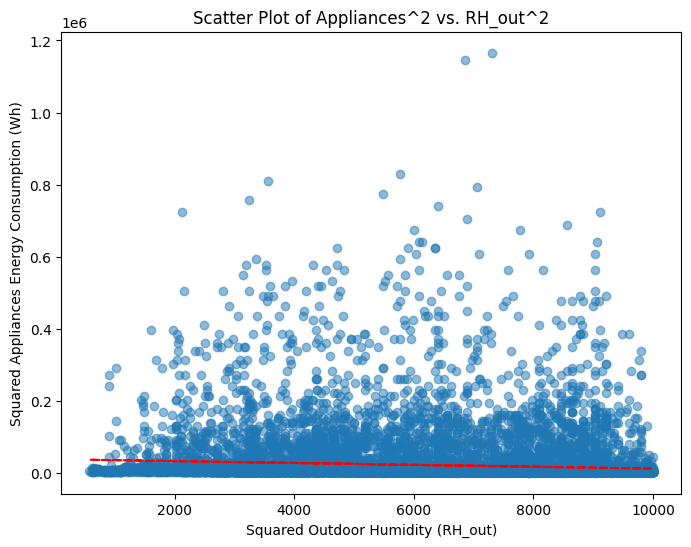

In [16]:
#this time do a squared transformation for appliances and RH_out and plot it with a trend line

# Square transform 'Appliances' and 'RH_out'
df['Appliances_sq'] = df['Appliances'] ** 2
df['RH_out_sq'] = df['RH_out'] ** 2

# Plot the squared transformed data with a trend line
plt.figure(figsize=(8, 6))
plt.scatter(df['RH_out_sq'], df['Appliances_sq'], alpha=0.5)
plt.xlabel('Squared Outdoor Humidity (RH_out)')
plt.ylabel('Squared Appliances Energy Consumption (Wh)')
plt.title('Scatter Plot of Appliances^2 vs. RH_out^2')

z = np.polyfit(df['RH_out_sq'], df['Appliances_sq'], 1)
p = np.poly1d(z)
plt.plot(df['RH_out_sq'], p(df['RH_out_sq']), "r--")

plt.show()

## Summarize

Task 1: Deal with the imbalacned Target Variable -> we transformed outcome variables into a log format. (Resolved)

Task 2: Consdier doing standardization.-> Depending on what ML we use.

For lasso and Ridge, we need to do standardize.

But once we use standardized data set, we have to use the standardized data set for all other models as well.

So two tracks where we use non-standradize dataset across all the models and we use standardized dataset across all the models.



#Dividing dataset into train, test and validation and exporting as csvs

In [17]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')
import csv


# Split data with the 'season' variable included in features
# Log-transform 'Appliances' before splitting
df['Appliances_log'] = np.log1p(df['Appliances'])
X = df.drop(['Appliances', 'Appliances_log'], axis=1)  # Use raw features for modeling
y = df['Appliances_log']  # Use log-transformed target

# Adjust split proportions
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Split 15% each



train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_df.to_csv('train_data.csv', index=False)
val_df.to_csv('val_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

files.download('train_data.csv')
files.download('val_data.csv')
files.download('test_data.csv')


print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

#put more on test data
#train 70
#val 15
#test 15

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training set size: 13814
Validation set size: 2960
Test set size: 2961


In [18]:
print("Number of rows in the cleaned dataset:", df.shape[0])

Number of rows in the cleaned dataset: 19735
